# Topic Modeling with Better Coherence Plot
Update: 23.04.2021<br>
Mai Vu

In [3]:
#Basic libraries
import random
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from collections import defaultdict

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

#Libraries for lemmatization
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#Lirary to check the language in text
from langdetect import detect

#Libraries for topic modeling
import gensim
from gensim import corpora
import pprint
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel

#For plotting
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# Init steps

In [4]:
#Read the data
eng_data = pd.read_csv('eng_abstracts.csv')

In [5]:
#Create eng_stopwords set and lemmatizer from NLTK library
eng_stopwords = set(stopwords.words('english')).union(gensim.parsing.preprocessing.STOPWORDS)
eng_stopwords.update({'thesis', 'study', 'research', 'group', 'part', 'work', 'use', 'new', 'based', 'using', 'people'}) #Add common words that appear too many times and no use in distinguishing topics
lemmatizer = WordNetLemmatizer()

In [6]:
def CalculateCoherenceRange(texts, bow, dictionary, start = 1, end = 20):
    """Function to calculate the coherence scores of different LDA models with the number of topics in the given range.
    Abstracts are divided into smaller subsets so that the coherence curve will be smoother.
    
    Args:
        (list) texts: abstracts in text.
        (list) bow: bag of words of abstracts.
        (Dictionary) dictionary: set of stopwords from NLTK library.
        (integers) start, end: number of topics' range.

    Returns:
        (list): coherence scores of different LDA models with the number of topics in the given range.
    """
    coherence = []
    n = len(bow)
    
    for num_topic in range(start, end + 1):
        np.random.seed(111)
        temp = []
        
        for i in range(10):
            index = np.random.choice(n, int(0.80 * n))
            t = [texts[x] for x in index]
            c = [bow[x] for x in index]
            LDA_model = LdaModel(c, num_topics = num_topic, id2word = dictionary, passes = 10, random_state = 111)
            cohm = CoherenceModel(model = LDA_model, texts = t, corpus = c, dictionary = dictionary, coherence = 'c_v')
            temp.append(cohm.get_coherence())
            
        print('.', end = " ")
        coherence.append(np.mean(temp))
        
    print()
    return coherence

In [7]:
def PlotKeywords(LDA_model, num_topic, num_word = 8):
    """Function to plot important keywords .
    Abstracts are divided into smaller subsets so that the coherence curve will be smoother.
    
    Args:
        (LdaModel) LDA_model: abstracts in text.
        (integer) num_topic: number of topics of the model.
        (integer) num_word: number of words to plot.

    Returns:
        None.
    """
    keywords = [[word for word, _ in LDA_model.show_topic(topicid, topn = 20)] for topicid in range(LDA_model.num_topics)]
    keywords_prob = [[beta for _, beta in LDA_model.show_topic(topicid, topn = 20)] for topicid in range(LDA_model.num_topics)]

    gs = gridspec.GridSpec(round(math.sqrt(num_topic)) + 1, round(math.sqrt(num_topic)) + 1)
    gs.update(wspace = 0.5, hspace = 0.5)
    plt.figure(figsize = (20, 15))
    for i in range(num_topic):
        ax = plt.subplot(gs[i])
        plt.barh(range(num_word), keywords_prob[i][:num_word])
        ax.invert_yaxis()
        ax.set_yticks(range(num_word))
        ax.set_yticklabels(keywords[i][:num_word])
        plt.grid()
        plt.title("Topic " + str(i + 1))

# 1. All words corpus

In [8]:
start_time = time.time() #Start count time

#Tokenization and delete punctuation, number, short words and stop words
allwords_pre_abstracts = []
count = defaultdict(int)
for abstract in eng_data['abstract_en']:
    tokens = []
    for token in nltk.word_tokenize(abstract.lower()):
        if token.isalpha() and token not in eng_stopwords and len(token) > 3:
            tokens.append(lemmatizer.lemmatize(token))
            count[token] += 1 #Count word frequencies
    allwords_pre_abstracts.append(tokens)

#Delete words that appear very few times
allwords_abstracts = [[token for token in abstract if count[token] > 10] for abstract in allwords_pre_abstracts]

print('- Finish preprocessing data (all words) in', round((time.time() - start_time)/60), 'min(s)')

- Finish preprocessing data (all words) in 1 min(s)


In [9]:
#Create dictionary for the given texts
allwords_dictionary = corpora.Dictionary(allwords_abstracts)
print(allwords_dictionary)

#Create the bag of words for all documents
allwords_bow = [allwords_dictionary.doc2bow(abstract) for abstract in allwords_abstracts]

Dictionary(6431 unique tokens: ['activity', 'actual', 'analyse', 'area', 'book']...)


## 1.1 Choose the number of topics

. . . . . . . . . . . . . . . . . . . . 
- Finish in 271 min(s)


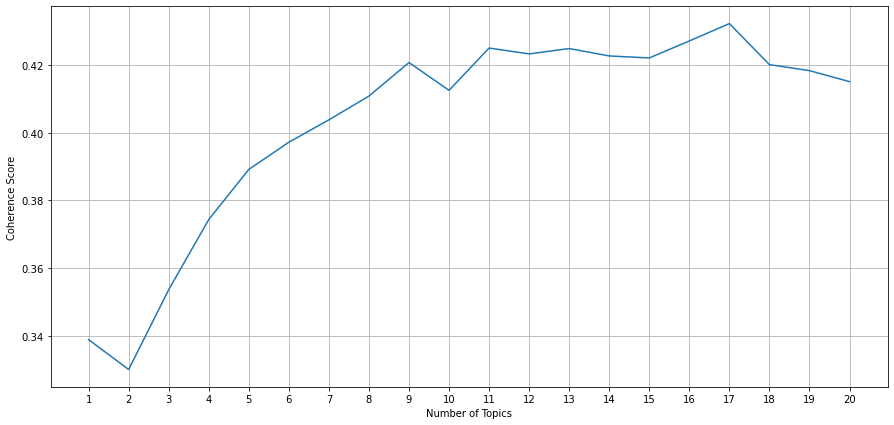

In [10]:
start_time = time.time() #Start count time
allwords_coherence = CalculateCoherenceRange(allwords_abstracts, allwords_bow, allwords_dictionary)
print('- Finish in', round((time.time() - start_time)/60), 'min(s)')

#Plot the coherence plot
plt.figure(figsize = (15, 7))
plt.plot(range(1, 21), allwords_coherence)
plt.xticks(range(1, 21))
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.grid()

## 1.2 LDA model with 9 topics

In [11]:
allwords_LDA_model1 = LdaModel(allwords_bow, num_topics = 9, id2word = allwords_dictionary, random_state = 111, passes = 30)

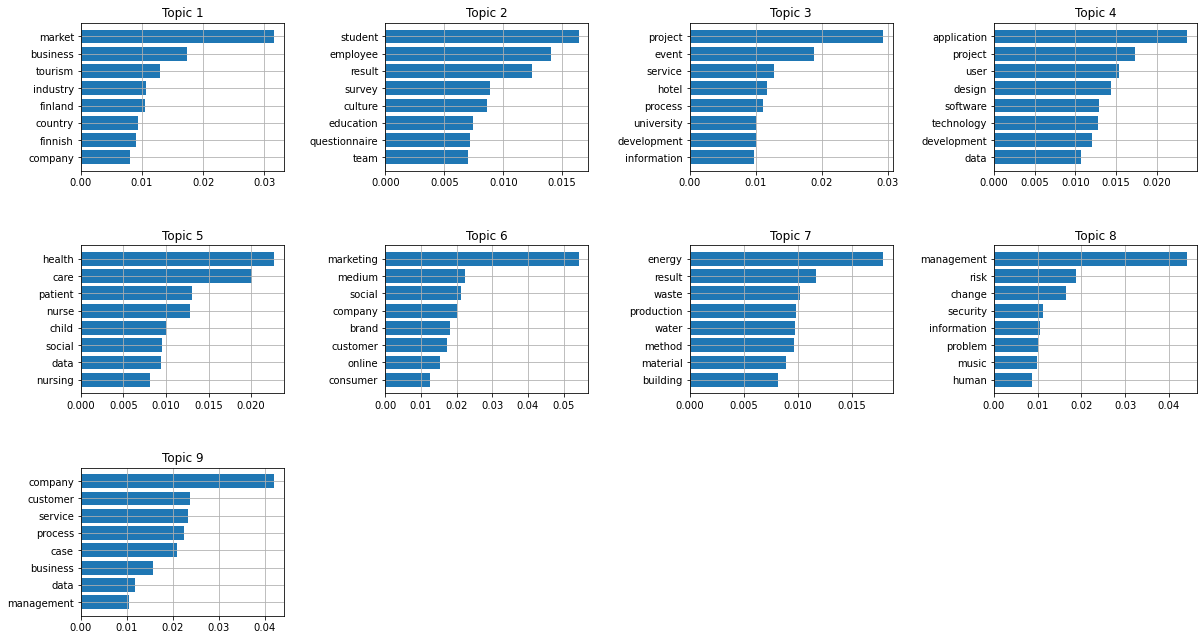

In [12]:
PlotKeywords(allwords_LDA_model1, 9)

In [13]:
#Calculate Coherence Score
allwords_coherence1 = gensim.models.CoherenceModel(model = allwords_LDA_model1, texts = allwords_abstracts, dictionary = allwords_dictionary, coherence = 'c_v')
print('Coherence Score:', round(allwords_coherence1.get_coherence(), 3))

Coherence Score: 0.423


In [14]:
#Display the topics
allwords_display_model1 = gensimvis.prepare(allwords_LDA_model1, allwords_bow, allwords_dictionary, sort_topics = False)
pyLDAvis.display(allwords_display_model1)

**GUESSING TOPICS:**<br>
Topic 1 - Tourism<br>
Topic 2 - Education \*<br>
Topic 3 - Project/Event \*<br>
Topic 4 - Information Technology<br>
Topic 5 - Healthcare<br>
Topic 6 - Marketing<br>
Topic 7 - Energy<br>
Topic 8 - Management \*<br>
Topic 9 - Customer Service<br><br>
\* Topic Seems not to be so clear<br>

I guess 9 topics is not enough as a topic might have hidden topics inside. For example, topic 3 has keywords 'sport', 'hotel', 'service', etc, which are quite mixed.<br>
Thus, I tried with 11 topics as below.

## 1.2 LDA model with 11 topics

In [15]:
allwords_LDA_model2 = LdaModel(allwords_bow, num_topics = 11, id2word = allwords_dictionary, random_state = 111, passes = 30)

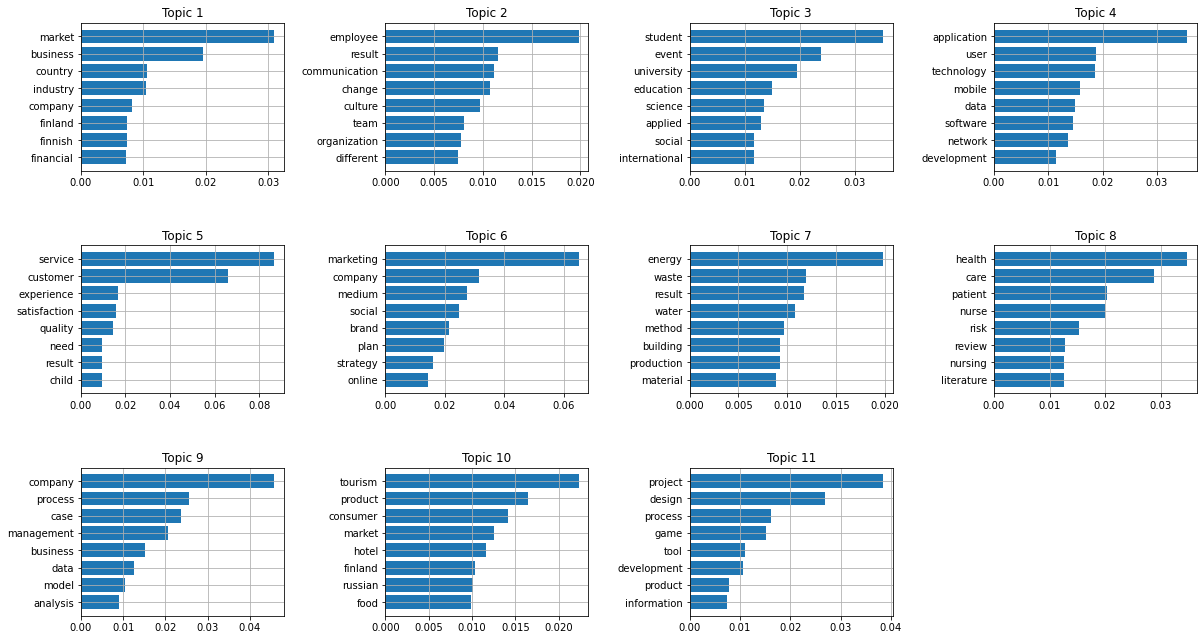

In [16]:
PlotKeywords(allwords_LDA_model2, 11)

In [17]:
#Calculate Coherence Score
allwords_coherence2 = gensim.models.CoherenceModel(model = allwords_LDA_model2, texts = allwords_abstracts, dictionary = allwords_dictionary, coherence = 'c_v')
print('Coherence Score:', round(allwords_coherence2.get_coherence(), 3))

Coherence Score: 0.461


In [18]:
#Display the topics
allwords_display_model2 = gensimvis.prepare(allwords_LDA_model2, allwords_bow, allwords_dictionary, sort_topics = False)
pyLDAvis.display(allwords_display_model2)

**GUESSING TOPICS:**<br>
Topic 1 - Market/Business<br>
Topic 2 - Cultural Inclusion<br>
Topic 3 - Education<br>
Topic 4 - Information Technology<br>
Topic 5 - Customer Service<br>
Topic 6 - Marketing<br>
Topic 7 - Energy<br>
Topic 8 - Healthcare<br>
Topic 9 - Case Company/Management<br>
Topic 10 - Tourism<br>
Topic 11 - Game Design<br>

Topics are a little bit clearer.

# 2. Only noun corpus

In [19]:
start_time = time.time() #Start count time

#Tokenization and delete punctuation, number, short words and stop words
nouns_pre_abstracts = []
count = defaultdict(int)
for abstract in eng_data['abstract_en']:
    noun = []
    for token in nltk.word_tokenize(abstract.lower()):
        if token.isalpha() and token not in eng_stopwords and len(token) > 3:
            for (word, pos) in nltk.pos_tag({lemmatizer.lemmatize(token)}):
                if pos[0] == 'N': #Take only noun
                    noun.append(word)
                    count[word] += 1 #Count word frequencies
    nouns_pre_abstracts.append(noun)

#Delete words that appear very few times
nouns_abstracts = [[token for token in abstract if count[token] > 10] for abstract in nouns_pre_abstracts]

end_time = time.time() #End count time
print('- Finish preprocessing data (nouns only) in', round((end_time - start_time)/60), 'min(s)')

- Finish preprocessing data (nouns only) in 16 min(s)


In [20]:
#Create dictionary for the given texts
nouns_dictionary = corpora.Dictionary(nouns_abstracts)
print(nouns_dictionary)

#Create the bag of words for all documents
nouns_bow = [nouns_dictionary.doc2bow(abstract) for abstract in nouns_abstracts]

Dictionary(4590 unique tokens: ['activity', 'analyse', 'area', 'book', 'business']...)


## 2.1 Choose the number of topics

. . . . . . . . . . . . . . . . . . . . 
- Finish in 227 min(s)


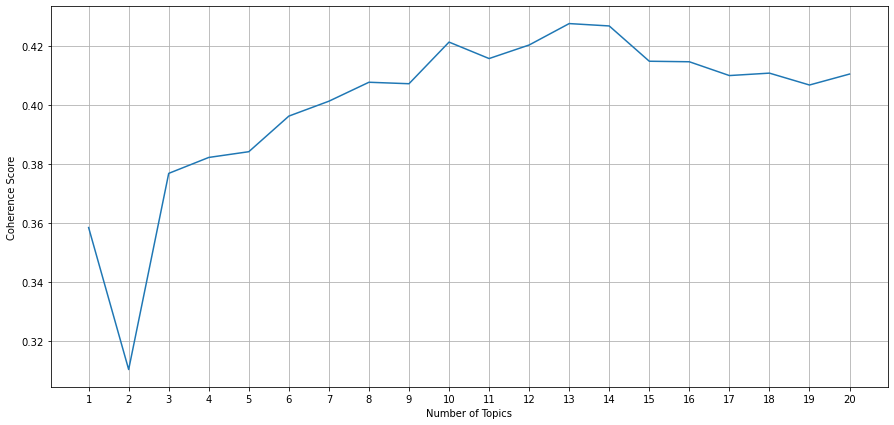

In [21]:
start_time = time.time() #Start count time
nouns_coherence = CalculateCoherenceRange(nouns_abstracts, nouns_bow, nouns_dictionary)
print('- Finish in', round((time.time() - start_time)/60), 'min(s)')

#Plot the coherence plot
plt.figure(figsize = (15, 7))
plt.plot(range(1, 21), nouns_coherence)
plt.xticks(range(1, 21))
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.grid()

## 2.2 LDA model with 8 topics

In [22]:
nouns_LDA_model1 = LdaModel(nouns_bow, num_topics = 8, id2word = nouns_dictionary, random_state = 111, passes = 50)

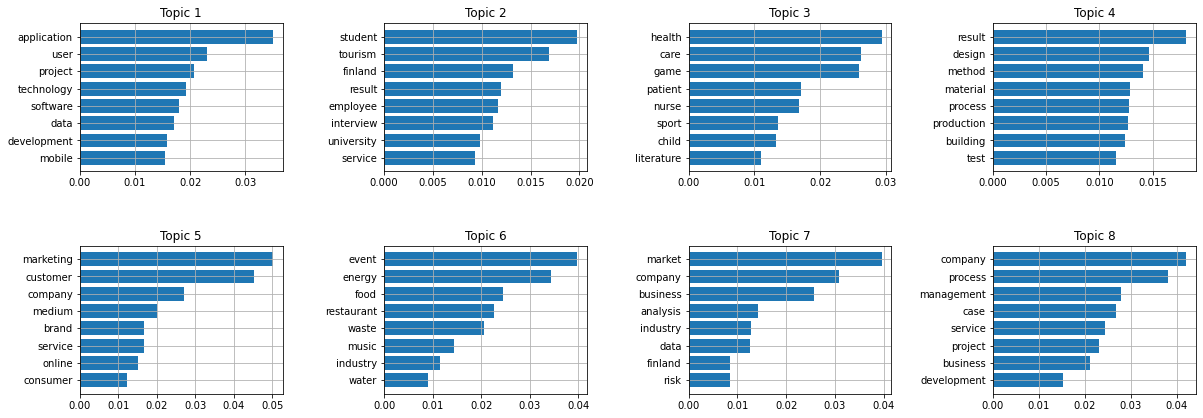

In [23]:
PlotKeywords(nouns_LDA_model1, 8)

In [24]:
#Calculate Coherence Score
nouns_coherence1 = gensim.models.CoherenceModel(model = nouns_LDA_model1, texts = nouns_abstracts, dictionary = nouns_dictionary, coherence = 'c_v')
print('Coherence Score:', round(nouns_coherence1.get_coherence(), 3))

Coherence Score: 0.404


In [25]:
#Display the topics
nouns_display_model1 = gensimvis.prepare(nouns_LDA_model1, nouns_bow, nouns_dictionary, sort_topics = False)
pyLDAvis.display(nouns_display_model1)

**GUESSING TOPICS:**<br>
Topic 1 - Information Technology<br>
Topic 2 - Tourism/Student \*<br>
Topic 3 - Healthcare<br>
Topic 4 - Construction<br>
Topic 5 - Marketing<br>
Topic 6 - Event/Energy \*<br>
Topic 7 - Market<br>
Topic 8 - Management/Process \*<br><br>
(\*) : Topic Seems not to be so clear<br>

I tried 10 topics instead.

## 2.3 LDA model with 10 topics

In [26]:
nouns_LDA_model2 = LdaModel(nouns_bow, num_topics = 10, id2word = nouns_dictionary, random_state = 111, passes = 50)

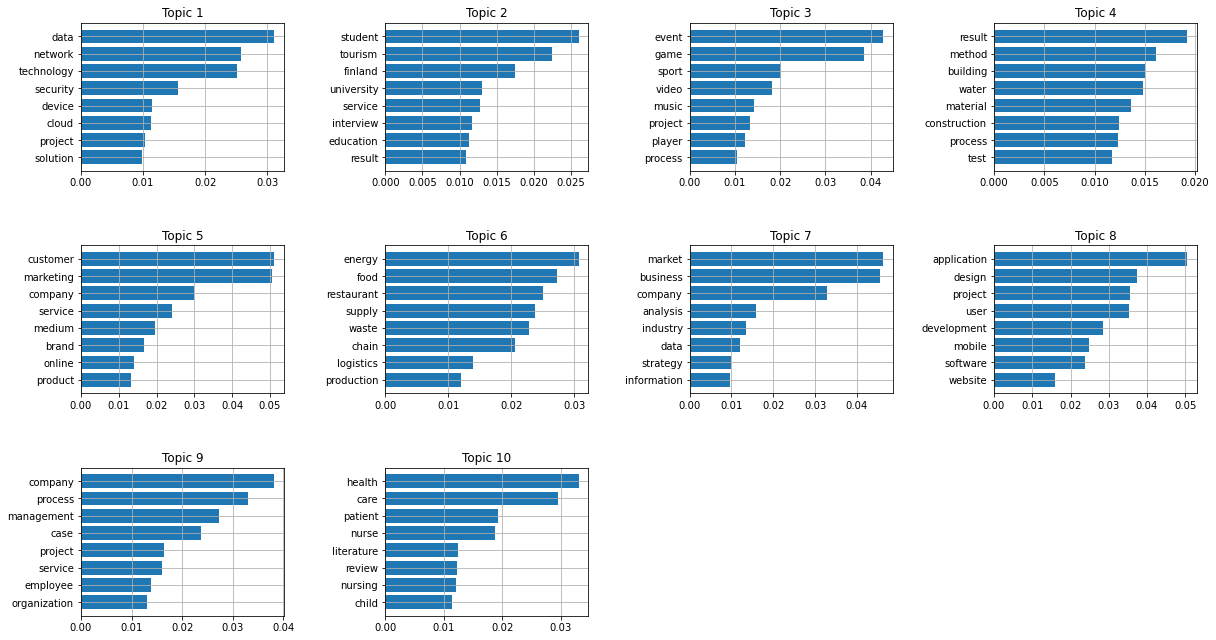

In [27]:
PlotKeywords(nouns_LDA_model2, 10)

In [28]:
#Calculate Coherence Score
nouns_coherence2 = gensim.models.CoherenceModel(model = nouns_LDA_model2, texts = nouns_abstracts, dictionary = nouns_dictionary, coherence = 'c_v')
print('Coherence Score:', round(nouns_coherence2.get_coherence(), 3))

Coherence Score: 0.437


In [29]:
#Display the topics
nouns_display_model2 = gensimvis.prepare(nouns_LDA_model2, nouns_bow, nouns_dictionary, sort_topics = False)
pyLDAvis.display(nouns_display_model2)

There are some overlaps, such as topic 10 is a mix of topics 2 and 7. Apparently, this is not a good model.